In [1]:
import os
import torch
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Utils.niiparsing import load_nii
import glob

from Utils.argparsing import get_args
from Preprocessing.data_init import organized_data_download
from Preprocessing.data_loading import BratsDataset

In [2]:
if __name__ == "__main__":

    data = BratsDataset()

(276599, 6)


In [3]:
x_train, x_test, y_train, y_test = train_test_split(data.x, data.y, test_size=0.3, random_state=42)


rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
x_train, y_train = rus.fit_resample(x_train, y_train)
x_test, y_test = rus.fit_resample(x_test, y_test)

def print_dis(arr):
    
    zeros = 0
    ones = 0

    for val in arr:
        if val==0:
            zeros+=1
        elif val==1:
            ones+=1

    print(zeros)
    print(ones)
    print()

print_dis(y_train)
print_dis(y_test)

17349
17349

7455
7455



In [4]:
svc = SVC(random_state=42, kernel='poly')
svc.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [5]:
predictions = svc.predict(x_test).reshape(-1)
y_test = y_test.reshape(-1)

# Calculate dice coefficient
dice = (2*np.sum(np.dot(predictions, y_test))) / (np.sum(y_test + predictions))

print('Dice coefficient is %.6f' % dice)

Dice coefficient is 0.788418


In [6]:
smooth=1.

def dice_coef_numpy(y_true, y_pred):

    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

dice_coef_numpy(y_test, predictions)

0.7884327851026234

In [7]:
svc.score(x_test, y_test)

0.79121395036888

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

def slice(x_path, y_path, depth):
    # Ground Truth
    x = load_nii(x_path)
    y = load_nii(y_path)

    plt.imshow(y[ : , : , depth], cmap='gray')
    plt.title("Segmentation Mask")
    plt.show()

    plt.imshow(x[ : , : , depth], cmap='gray')
    plt.title("Slice")
    plt.show()

    orig_shape = x.shape

    y = y.reshape(-1)
    x = x.reshape(-1)

    for i, val in enumerate(y):
        if val != 0:
            x[i] = 1024

    x = x.reshape(orig_shape)


    plt.imshow(x[ : , : , depth], cmap='gray')
    plt.title("Superimposed Mask")
    plt.show()

    # Predictions
    x = load_nii(x_path)
    x = x / x.max()
    x = np.pad(x, ((1, 1), (1, 1), (0, 0)), mode='constant')

    windows = []


    # Parameterizing sliding window
    for row in range(0, x.shape[0] - 2):
        for col in range(0, x.shape[1] - 2):

            # Creating sliding window across slice
            x_window = x[row : row + 3, col : col + 3, depth - 1 : depth + 2]

            windows.append(np.array(x_window).reshape(-1))

    inp = np.concatenate((
                             np.mean(windows, axis=1).reshape(-1, 1), 
                             np.std(windows, axis=1).reshape(-1, 1), 
                             np.var(windows, axis=1).reshape(-1, 1),
                             np.max(windows, axis=1).reshape(-1, 1),
                             np.min(windows, axis=1).reshape(-1, 1),
                             np.median(windows, axis=1).reshape(-1, 1)), axis=1)

    preds = svc.predict(inp)
    preds = preds.reshape(240, 240)
    plt.imshow(preds[ : , : ], cmap='gray')
    plt.title("Predicted Tumor")
    plt.show()

    y = load_nii(y_path)
    print(dice_coef_numpy(y[ : , : , depth].reshape(-1), preds.reshape(-1)))
    print(svc.score(inp, np.array(y[ : , : , depth]).reshape(-1)))

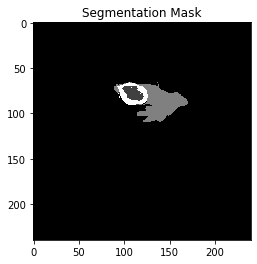

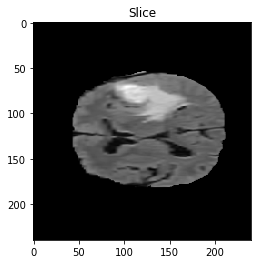

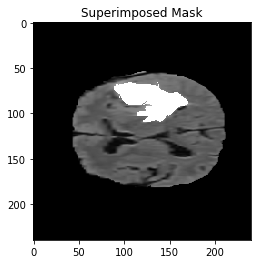

{0, 1}


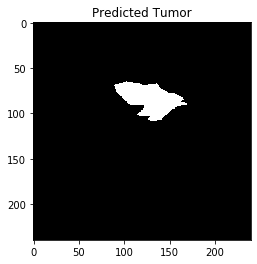

1.2671035805626598
0.9688715277777777


'\nfrom glob import glob\n\nfor x_path in glob("../organized_data/HGG/*flair.nii.gz"):\n    \n    split = x_path.split(\'flair\')\n    y_path = split[0] + \'seg\' + split[1]\n'

In [29]:
x_path = '../organized_data/HGG/BraTS19_2013_10_1_flair.nii.gz'
y_path = '../organized_data/HGG/BraTS19_2013_10_1_seg.nii.gz'
depth = 80

slice(x_path, y_path, depth)

"""
from glob import glob

for x_path in glob("../organized_data/HGG/*flair.nii.gz"):
    
    split = x_path.split('flair')
    y_path = split[0] + 'seg' + split[1]
"""

# Intensity equalization, contrast

In [21]:
import matplotlib.pyplot as plt
from Utils.niiparsing import load_nii
import nibabel

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)
                
def slice_viewer(volume, volume2):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].volume = volume
    ax[0].index = volume.shape[0] // 2
    ax[0].imshow(volume[ax[0].index])
    ax[0].set_title('Ground Truth')
    ax[1].volume = volume2
    ax[1].index = volume2.shape[0] // 2
    ax[1].imshow(volume2[ax[1].index])
    ax[1].set_title('Prediction')
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax, ax2 = fig.axes[0], fig.axes[1]
    if event.key == 'j':
        previous_slice(ax)
        previous_slice(ax2)
    elif event.key == 'k':
        next_slice(ax)
        next_slice(ax2)
    fig.canvas.draw()

def previous_slice(ax):
    #Go to the previous slice.
    volume = ax.volume
    ax.index = (ax.index - 3) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    #Go to the next slice.
    volume = ax.volume
    ax.index = (ax.index + 3) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])
    
def show_tumors(img, seg):
    for depth in range(seg.shape[2]):
        for height in range(seg.shape[0]):
            for width in range(seg.shape[1]):
                if seg[height][width][depth] != 0:
                    img[height][width][depth] = 700

In [26]:
img = load_nii('../organized_data/HGG/BraTS19_2013_10_1_flair.nii.gz')

x = img / img.max()
x = np.pad(x, ((1, 1), (1, 1), (0, 0)), mode='constant')

windows = []


# Parameterizing sliding window
for row in range(0, x.shape[0] - 2):
    for col in range(0, x.shape[1] - 2):

        # Creating sliding window across slice
        x_window = x[row : row + 3, col : col + 3, depth - 1 : depth + 2]

        windows.append(np.array(x_window).reshape(-1))

inp = np.concatenate((
                         np.mean(windows, axis=1).reshape(-1, 1), 
                         np.std(windows, axis=1).reshape(-1, 1), 
                         np.var(windows, axis=1).reshape(-1, 1),
                         np.max(windows, axis=1).reshape(-1, 1),
                         np.min(windows, axis=1).reshape(-1, 1),
                         np.median(windows, axis=1).reshape(-1, 1)), axis=1)

img_predict = svc.predict(inp).reshape(240, 240)


seg = load_nii('../organized_data/HGG/BraTS19_2013_10_1_seg.nii.gz')

show_tumors(img, seg)
show_tumors(img, img_predict)

slice_viewer(img, img_predict)

IndexError: tuple index out of range